# Duplicate question detection

**The main goal**: create autodetection of duplicate questions based on question text.  
This is important for companies like Quora, or Stack Overflow where multiple questions posted are duplicates of questions already answered. If a duplicate question is spotted by an algorithm, the user can be directed to it and reach the answer faster.  

An example of two duplicate questions is 'How do I read and find my YouTube comments?' and 'How can I see all my Youtube comments?', and non duplicate questions is 'What's causing someone to be jealous?' and 'What can I do to avoid being jealous of someone?'.

Dataset include questions from Quora. The main goal is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The dataset consists of a training set of 404290 pairs of questions and a test set of 3563475. Both sets include the following columns:  
**id** - the id of a training set question pair;  
**qid1**, **qid2** - unique ids of each question (only available in train.csv);  
**question1**, **question2** - the full text of each question;  
**is_duplicate** - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

The main steps:  
1. Data preprocessing:  
    1.1. Data cleaning: remove e-mails, urls, numbers, datetimes, punctuation, extra spaces, special characters and etc. (regex, nltk)

    1.2. Remove stopwords (nltk) (pay attention: some stopwords can change lexical meaning)

    1.3. Tokenization (nltk)
    
    1.4. Lemmatization (WordNetLemmatizer)  
2. Vectorization(CountVectorizer/TfidfVectorizer(tune parametrs (n_grams, max_features and others)))  
3. Create classifier (XGBoost, RandomForest and others)  
4. Tune classifier parametrs (GridSearchCV)  
5. Estimate classifier performance  

Use your knowledge to create machine learning pipeline for the most accurate predictions. Metric for maximization - **ROC_AUC**. Expected ROC_AUC > 0.86.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
from wordcloud import WordCloud

In [2]:
train_data = pd.read_csv('data/train.csv');
test_data = pd.read_csv('data/test.csv');
train_data.dropna(inplace=True)
train_data['question1'] = train_data['question1'].apply(str)
train_data['question2'] = train_data['question2'].apply(str)

print('Total: ', len(train_data['qid1']))
print("Unique: ", len(set(train_data['qid1'])))
train_data.shape, test_data.shape

C:\Users\nikit\AppData\Local\Temp\ipykernel_13188\1535080336.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv('data/test.csv');


Total:  404287
Unique:  290652


((404287, 6), (3563475, 3))

In [5]:
test_data.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


<AxesSubplot:>

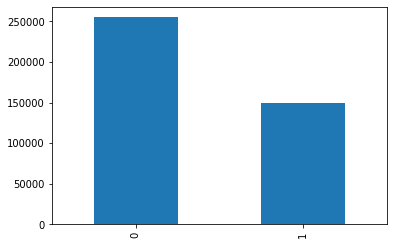

In [3]:
train_data.is_duplicate.value_counts().plot.bar()

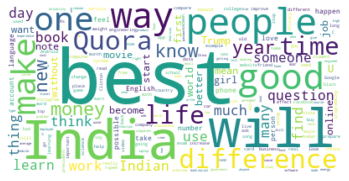

In [4]:
plt.imshow(
    WordCloud(
        collocations = False,
        background_color = 'white'
        ).generate(
            " ".join(
                train_data.question1.apply(str)
                )
            ),
    interpolation='bilinear')
plt.axis("off")
plt.show()

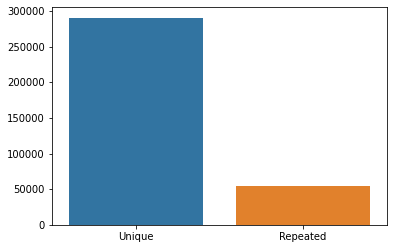

In [5]:
x = ["Unique" , "Repeated"]
y =  [len(np.unique(train_data.qid1)), np.sum(train_data.qid1.value_counts() > 1)]

sn.barplot(x=x,y=y);

In [35]:
number_words1 = train_data['question1'].apply(lambda row: len(row.split(" ")))
number_words2 = train_data['question2'].apply(lambda row: len(row.split(" ")))
diff_number_words = number_words1 - number_words2
diff_number_words = np.absolute(diff_number_words)
diff_number_words = diff_number_words.values

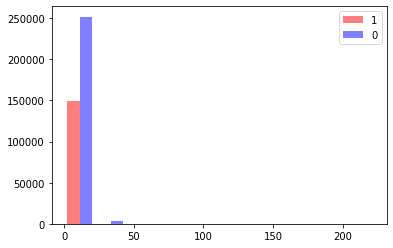

In [36]:
plt.hist([
    diff_number_words[np.where(train_data['is_duplicate'])[0]],
    diff_number_words[np.where(train_data['is_duplicate'] == False)[0]]
], color=['r', 'b'], alpha=0.5)
plt.legend(["1", "0"])

In [37]:
print(np.mean(diff_number_words[np.where(train_data['is_duplicate'])[0]]))
print(np.mean(diff_number_words[np.where(train_data['is_duplicate'] == False)[0]]))

2.4218393037792354
4.442550505050505


In [38]:
import re
import nltk
from nltk.stem import SnowballStemmer, WordNetLemmatizer

In [39]:
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')

def text_preprocess(text: str) -> str:
    text = re.sub(r'https*\S+', ' ', text)
    text = re.sub(r'@\S+', ' ', text)
    text = re.sub(r'#\S+', ' ', text)
    text = re.sub(r'\'\w+', '', text)
    text = re.sub(r'\w*\d+\w*', '', text)
    text = re.sub(r'\s{2,}', ' ', text)
    text_tokens = nltk.word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if word not
                         in stop_words and len(word) != 1]
    return tokens_without_sw


def text_preprocess_stem(text: str) -> str:
    text = text_preprocess(text)
    text = [stemmer.stem(i) for i in text]
    return " ".join(text)


def text_preprocess_lem(text: str) -> str:
    text = text_preprocess(text)
    return map(lemmatizer.lemmatize, text)

In [40]:
train_data['question1_stem'] = train_data['question1'].apply(
    text_preprocess_stem)
train_data['question2_stem'] = train_data['question2'].apply(
    text_preprocess_stem)

In [44]:
number_of_similar_words = np.array([len(list(
    set(row['question1_stem'].split(" ")).
        intersection(row['question2_stem'].
                     split(" ")))) 
    for _, row in train_data.iterrows()])

In [45]:
train_data['words_common'] = number_of_similar_words

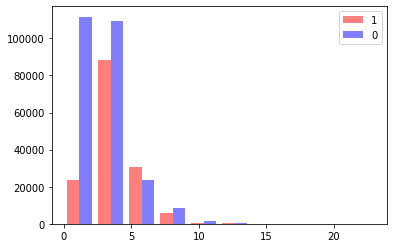

In [47]:
plt.hist([
    number_of_similar_words[np.where(train_data['is_duplicate'])[0]],
    number_of_similar_words[np.where(train_data['is_duplicate'] == False)[0]]
], color=['r', 'b'], alpha=0.5)
plt.legend(["1", "0"])